In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Carregar os dados

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Carregar os dados
gluon_df = pd.read_csv('/content/drive/MyDrive/ML/Seminario/g_jets.csv', header=None, delimiter='\s+')
quark_df = pd.read_csv('/content/drive/MyDrive/ML/Seminario/q_jets.csv', header=None, delimiter='\s+')
top_df = pd.read_csv('/content/drive/MyDrive/ML/Seminario/t_jets.csv', header=None, delimiter='\s+')


In [ ]:
# Função para reshape
def reshape_data(df):
    return df.values.reshape(-1, 30, 4)


data_g = reshape_data(gluon_df)
data_q = reshape_data(quark_df)
data_t = reshape_data(top_df)

# Combinar dados e criar rótulos
data = np.concatenate((data_g, data_t, data_q), axis=0)
labels = np.concatenate((
    np.zeros(len(data_g)),  # 0 para gluons
    np.ones(len(data_t)),   # 1 para tops
    np.full(len(data_q), 2) # 2 para quarks
))

# Extrair coordenadas eta_rel, phi_rel e pt_rel
eta = data[:, :, 0]
phi = data[:, :, 1]
pt = data[:, :, 2]

# Função para calcular a diferença mínima de ângulo considerando a periodicidade de phi
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    dphi = np.mod(dphi + np.pi, 2 * np.pi) - np.pi
    return dphi

# Calcular R_ij
def calculate_Rij(eta, phi):
    num_particles = eta.shape[1]
    R_ij = np.zeros((eta.shape[0], num_particles, num_particles))

    for i in range(num_particles):
        for j in range(num_particles):
            delta_eta = eta[:, i] - eta[:, j]
            delta_phi_ij = delta_phi(phi[:, i], phi[:, j])
            R_ij[:, i, j] = np.sqrt(delta_eta**2 + delta_phi_ij**2)

    return R_ij

R_ij = calculate_Rij(eta, phi)

# Extrair características de R_ij (exemplo: média e desvio padrão)
features_Rij = np.zeros((R_ij.shape[0], 2))
features_Rij[:, 0] = R_ij.mean(axis=(1, 2))
features_Rij[:, 1] = R_ij.std(axis=(1, 2))

# Extrair características de pt_rel (exemplo: média, desvio padrão, valor máximo)
features_pt = np.zeros((pt.shape[0], 3))
features_pt[:, 0] = pt.mean(axis=1)
features_pt[:, 1] = pt.std(axis=1)
features_pt[:, 2] = pt.max(axis=1)

# Extrair características de eta e phi (exemplo: média, desvio padrão)
features_eta = np.zeros((eta.shape[0], 2))
features_eta[:, 0] = eta.mean(axis=1)
features_eta[:, 1] = eta.std(axis=1)

features_phi = np.zeros((phi.shape[0], 2))
features_phi[:, 0] = phi.mean(axis=1)
features_phi[:, 1] = phi.std(axis=1)

# Concatenar todas as características
features = np.concatenate((features_Rij, features_pt, features_eta, features_phi), axis=1)

# Concatenar todas as características
features = np.concatenate((features_Rij, features_pt), axis=1)

In [ ]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [ ]:
# Pré-processamento dos dados
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Construir o modelo de rede neural
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Adicionando dropout para reduzir overfitting
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilar o modelo com uma taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo por mais épocas
history = model.fit(X_train_normalized, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Avaliar o modelo
test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test_encoded)
print('Test Accuracy:', test_accuracy)

# Previsões
y_pred = np.argmax(model.predict(X_test_normalized), axis=-1)



Epoch 1/50
10518/10518 [==============================] - 32s 3ms/step - loss: 0.7122 - accuracy: 0.7006 - val_loss: 0.6691 - val_accuracy: 0.7206
Epoch 2/50
10518/10518 [==============================] - 33s 3ms/step - loss: 0.6850 - accuracy: 0.7150 - val_loss: 0.6624 - val_accuracy: 0.7235
Epoch 3/50
10518/10518 [==============================] - 31s 3ms/step - loss: 0.6814 - accuracy: 0.7175 - val_loss: 0.6582 - val_accuracy: 0.7286
Epoch 4/50
10518/10518 [==============================] - 32s 3ms/step - loss: 0.6781 - accuracy: 0.7194 - val_loss: 0.6607 - val_accuracy: 0.7230
Epoch 5/50
10518/10518 [==============================] - 33s 3ms/step - loss: 0.6762 - accuracy: 0.7203 - val_loss: 0.6552 - val_accuracy: 0.7291
Epoch 6/50
10518/10518 [==============================] - 32s 3ms/step - loss: 0.6756 - accuracy: 0.7213 - val_loss: 0.6663 - val_accuracy: 0.7192
Epoch 7/50
10518/10518 [==============================] - 33s 3ms/step - loss: 0.6738 - accuracy: 0.7218 - val_loss: 0

In [39]:
# Métricas de avaliação
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)


# Converter label_encoder.classes_ para uma lista de strings
class_names = list(map(str, label_encoder.classes_))

# Exibir o relatório de classificação com as classes corretas
print("\nRelatório de Classificação:")
print(classification_report(y_test_encoded, y_pred, target_names=class_names))


Matriz de Confusão:
[[24121  5665  5697]
 [ 3971 29067  2594]
 [ 5747  3960 24354]]

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.71      0.68      0.70     35483
         1.0       0.75      0.82      0.78     35632
         2.0       0.75      0.72      0.73     34061

    accuracy                           0.74    105176
   macro avg       0.74      0.74      0.74    105176
weighted avg       0.74      0.74      0.74    105176



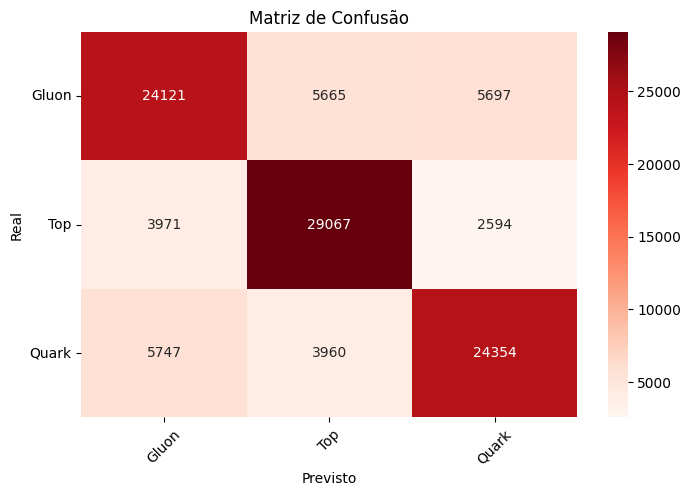

In [40]:
# Plot da matriz de confusão com rótulos
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')

# Definir rótulos manualmente
tick_labels = ['Gluon', 'Top', 'Quark']

# Adicionar rótulos para as classes
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45)
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0)

plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')

plt.show()

<Figure size 1000x600 with 0 Axes>

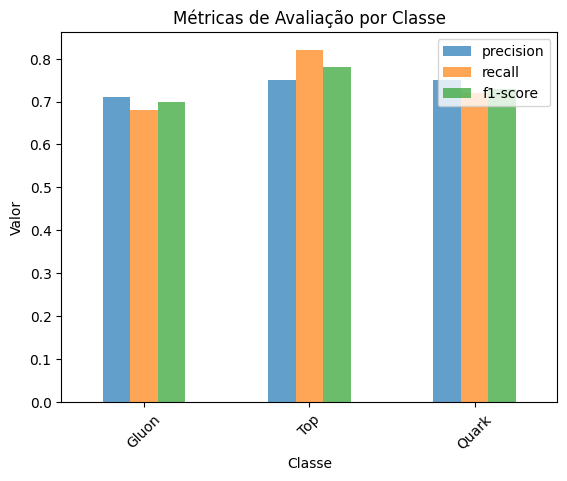

In [42]:
# Métricas para cada classe
class_metrics = {}

# Obter o relatório de classificação como uma lista de linhas
report_lines = classification_report(y_test_encoded, y_pred, target_names=class_names).split('\n')

# Iterar sobre as linhas do relatório (ignorando a primeira e última linhas)
for line in report_lines[2:-5]:
    # Dividir a linha em palavras
    words = line.split()
    # Extrair o nome da classe
    class_name = words[0]
    # Extrair as métricas de precisão, recall e f1-score
    precision = float(words[1])
    recall = float(words[2])
    f1_score = float(words[3])
    # Armazenar as métricas em um dicionário
    class_metrics[class_name] = {'precision': precision, 'recall': recall, 'f1-score': f1_score}

# Plotar as métricas de precisão, recall e f1-score
plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame.from_dict(class_metrics, orient='index')
metrics_df.plot(kind='bar', alpha=0.7)
plt.title('Métricas de Avaliação por Classe')
plt.xlabel('Classe')
plt.ylabel('Valor')
plt.xticks(ticks=[0, 1, 2], labels=['Gluon', 'Top', 'Quark'], rotation=45)
plt.legend(loc='upper right')
plt.show()

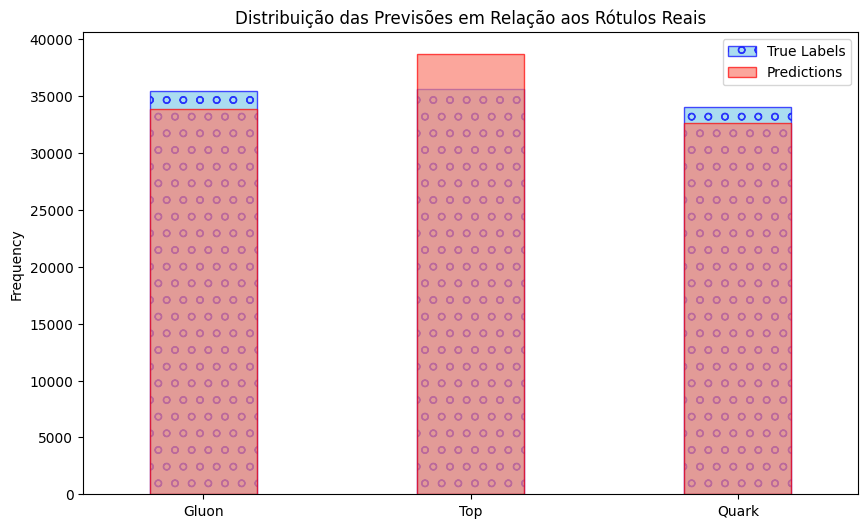

In [43]:
# Plotar gráfico da distribuição das previsões em relação aos rótulos reais
true_counts = pd.Series(y_test_encoded).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

plt.figure(figsize=(10, 6))
true_counts.plot(kind='bar', color='skyblue', alpha=0.7, label='True Labels', hatch='o', edgecolor='blue', width=0.4)
pred_counts.plot(kind='bar', color='salmon', alpha=0.7, label='Predictions', edgecolor='red', width=0.4)

plt.title('Distribuição das Previsões em Relação aos Rótulos Reais')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['Gluon', 'Top', 'Quark'], rotation=0)
plt.legend()
plt.show()